<a href="https://colab.research.google.com/github/lauramaria99/Se-alesFisiologicas/blob/main/Proyecto3_Grupo9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Programa de Bioingeniería** 

**Bioseñales y Sistemas** 

**Proyecto 3**

**Estudiantes:** 

Isabella Ariza Cuberos C.C 1152470641 - Maria Camila Parra Córdoba C.C 1233191182 - Laura María Muñoz Bravo C.C 1216729952.



In [ ]:
#Se importan las librerias básicas.
import librosa
import librosa.display
import numpy as np;
import matplotlib.pyplot as plt;
import scipy.io as sio;
from astropy.stats import median_absolute_deviation
import pandas as pd

#Se importa la libreria scipy que contiene herramientas estadísticas.
import scipy.stats as stats 

#Se ignoran las alertas para mejorar la visualización.
import warnings 
warnings.filterwarnings("ignore") 

In [ ]:
#Se importa y se activa "Drive" para acceder a los respectivos archivos de audio y texto.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Se importa la librería glob para acceder a los archivos de una ruta en específico.
import glob
#Extracción de los archivos de texto y de audio. 
txt=glob.glob('/content/drive/MyDrive/Lab Bioseñales/audio_and_txt_files/*.txt')
txt=sorted(txt)
wav=glob.glob('/content/drive/MyDrive/Lab Bioseñales/audio_and_txt_files/*.wav')
wav=sorted(wav)

## **2. Rutina de filtrado de la señal de auscultación**



In [ ]:
#Se importa la librerñia correspondiente para realizar los filtros. 
from linearFIR import filter_design, mfreqz
import scipy.signal as signal

In [ ]:
#Función que contiene los filtros pasa bajas y pasa altas. 
def filtro(senal,sr):
  fs = sr;
  #Diseño del filtro pasa-bajas.
  order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 2000, revfilt = 0);
  #Diseño del filtro pasa-altas.
  order, highpass = filter_design(fs, locutoff = 100, hicutoff = 0, revfilt = 1);

  #Se aplica el filtro pasa altas a la señal.
  y_hp = signal.filtfilt(highpass, 1, senal);

  #Se aplica el filtro pasa bajas a la señal con el pasa altas aplicado.
  y_bp = signal.filtfilt(lowpass, 1, y_hp); 

  #Se convierte a array
  y_bp = np.asfortranarray(y_bp)

  return y_bp,fs

500.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [2250.] Hz

25.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [87.5] Hz



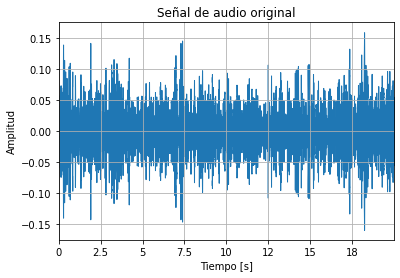

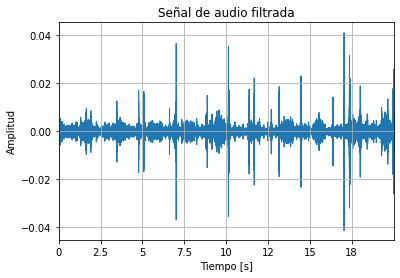

In [ ]:
#EJEMPLO DE APLICACIÓN DE FILTROS PASA BAJAS Y PASA ALTAS. 
senal=wav[1]
#Se extrae la señal y frecuencia de muestreo.
y, sr = librosa.load(senal) 
y_f,fs=filtro(y,sr)

#Gráfica de la señal de audio orginal y filtrada.
librosa.display.waveplot(y, sr=sr);
plt.title('Señal de audio original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

#Gráfica de la señal de audio filtrada.
librosa.display.waveplot(y_f, sr=fs);
plt.title('Señal de audio filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

## **3. Filtrado Wavelet**

In [ ]:
%%capture
#Se importan las funciones definidas en el proyecto 2, requeridas para realizar la limpieza Wavelet.
from proyecto2 import mallat,ruido,limpieza,reconstruccion

In [ ]:
#Función que realiza el filtrado Wavelet. 
def wavelet(y_f,fs,tipo,umb,pond):
  
  #Posibles opciones para la combinación de filtrado. 
  '''
  tipo = 'hard' o 'soft'
  umb = 'universal' , 'minimax' o 'sure'
  pond = 'global' o 'por nivel'
  '''
  #Se aplica el algoritmo de mallat con tres niveles de descomposición.
  aprox, detalle=mallat(y_f,3,'haar') 
  #Estimación del nivel de ruido.
  stdc=ruido(aprox,detalle) 
  #Limpieza Wavelet
  aproxi,detallee,thr,stdc1=limpieza(aprox,detalle,stdc,tipo,umb,pond)
  #Reconstrucción de la señal. 
  rec=reconstruccion(aproxi,detallee,y_f,'haar')
  fil=y_f[0:len(rec)]-rec
  
  #Se realiza la conversión a array. 
  f = np.asfortranarray(rec)
  g = np.asfortranarray(fil)

  return f,g

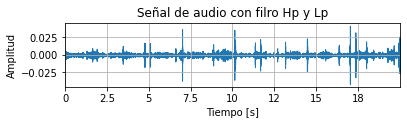

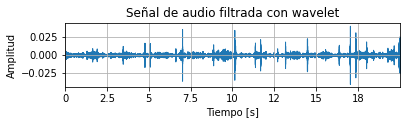

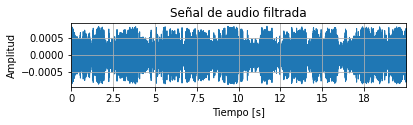

In [ ]:
#EJEMPLO DE FILTRADO CON WAVELET. 
f,g= wavelet(y_f,fs,'soft','minimax','por nivel')

#Guarda la señal filtrada como audio.
librosa.output.write_wav('senal.wav',g,fs)

#Gráficas de la señal filtrada mediante filtros pasa altas, pasa bajas y wavelet. 
figura=plt.figure()
plt.subplot(3,1,1);
librosa.display.waveplot(y_f, sr=fs);
plt.title('Señal de audio con filro Hp y Lp')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.subplot(3,1,2)
librosa.display.waveplot(f,sr=fs);
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal de audio filtrada con wavelet")
plt.grid()
plt.show()

plt.subplot(3,1,3)
librosa.display.waveplot(g,sr=fs);
plt.title('Señal de audio filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
figura.subplots_adjust(hspace=0.5)


Al implementar la función que permite realizar el filtrado Wavelet con la finalidad de eliminar ruidos cardiacos, se realizan pruebas de escritorio para determinar cual es la combinación de parámetros más adecuada para dicho proceso de tal manera que no haya eliminación de datos relevantes de los ciclos respiratorios, es por eso, que se llega a la conclusión de que utilizar el tipo de umbralización '*soft*', estimación del umbral '*minimax*' y tipo de ponderación '*por nivel*' es la mejor alternativa para realizar el filtrado. 



## **4. Preprocesamiento de la señal**

In [ ]:
#Función para realizar el preprocesamiento de la señal. 
def pre(y,sr,tipo,umb,pond):

  #Se llaman las funciones del filtro pasa altas, pasa bajas y Wavelet. 
  yf, fs= filtro(y,sr)
  w,fi = wavelet(yf,fs,tipo,umb,pond)

  return yf,w,fi

500.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [2250.] Hz

25.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [87.5] Hz



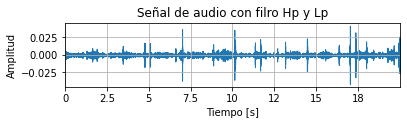

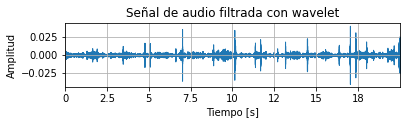

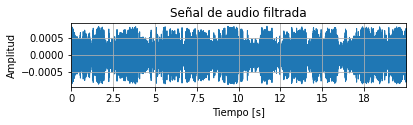

In [ ]:
#EJEMPLO DEL PREPROCESAMIENTO DE LA SEÑAL. 
yf,w,fi=pre(y,sr,'soft','minimax','por nivel')

#Gráficas de la señal filtrada mediante filtros pasa altas, pasa bajas y wavelet.
figura=plt.figure()
plt.subplot(3,1,1);
librosa.display.waveplot(yf, sr=fs);
plt.title('Señal de audio con filro Hp y Lp')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.subplot(3,1,2)
librosa.display.waveplot(w,sr=fs);
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal de audio filtrada con wavelet")
plt.grid()
plt.show()

plt.subplot(3,1,3)
librosa.display.waveplot(fi,sr=fs);
plt.title('Señal de audio filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
figura.subplots_adjust(hspace=0.5)

## **5. Extracción de ciclos respiratorios**

In [ ]:
#función que permite la extracción de los ciclos respiratorios. 
def ciclos(a1,t1):
  audio = a1
  texto = t1
  #Extracción de la señal y frecuencia de muestreo.
  y, sr = librosa.load(audio) 
  #Se implementa la función de preprocesamiento.
  yf,w,fi=pre(y,sr,'soft','minimax','por nivel')
  #Extracción de los archivos de texto. 
  t=np.loadtxt(texto)
  w=0
  con=[]
  sib=[]
  cre=[]
  #Ciclo que permite la extracción de los respectivos archivos. 
  for i in range(0,len(t)):
    h=0
    j=2
    tt=t[i][h+1]-t[i][h]
    #Puntos de la nueva señal en epocas
    s=fi[w:int(w+(tt*sr))] 
    #Número de muestras
    w=int(w+(tt*sr))

    #Condicionales para añadir los datos a una lista dependiendo del grupo al cual pertenezcan. 
    if t[i][j]==1 and t[i][j+1]==0:
      cre.append(s)
    elif t[i][j]==0 and t[i][j+1]==1:
      sib.append(s)  
    elif  t[i][j]==0 and t[i][j+1]==0:
      con.append(s)   

  return con,sib,cre

In [ ]:
#EJEMPLO DE LA EXTRACCIÓN DE CILOS RESPIRATORIOS. 
#Ruta de los archivos de audio y texto. 
a='/content/drive/MyDrive/Lab Bioseñales/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav'
b='/content/drive/MyDrive/Lab Bioseñales/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt'
con,sib,cre=ciclos(a,b)

#Imprime la cantidad de ciclos normales, sibilatentes y crepitantes. 
print('Ciclos normales:',len(con))
print('Ciclos con sibilancias:',len(sib))
print('Ciclos con crepitancias:',len(cre))

500.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [2250.] Hz

25.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [87.5] Hz

Ciclos normales: 12
Ciclos con sibilancias: 0
Ciclos con crepitancias: 0


## **Comparaciones de la densidad espectral de potencia entre pacientes con ciclos normales, con sibilancias y crepitancias.**

### **Recorte de la señal**

In [ ]:
#Función que realiza el recorte de la señal. 
def recorte(wav,txt):
  n=[]
  nc=[]
  ns=[]
  #Se agregan los elementos de cada una de las listas como un elemento más dentro de otra lista. 
  for i in range(0,len(wav)):
    con1,sib1,cre1=ciclos(wav[i],txt[i])
    n.extend(con1)
    nc.extend(cre1)
    ns.extend(sib1)
  ln=[]
  lnc=[]
  lns=[]
  #Ciclos "For" para devolver la longitud de los elementos de las listas. 
  #Longitud de ciclos normales. 
  for j in range(0,len(n)):
    l=len(n[j])
    ln.append(l)
  #Longitud de ciclos crepitantes. 
  for j in range(0,len(nc)):
    lc=len(nc[j])
    lnc.append(lc)
  #Longitud de ciclos sibilantes. 
  for j in range(0,len(ns)):
    ls=len(ns[j])
    lns.append(ls)

  #Recorte de los ciclos respiratorios a 40.000 muestras.  
  #Ciclos normales.
  normal=[]
  for w in range(0,len(ln)):
    d=ln[w]
    if d>=40000:
      z=n[w][0:40000]
      normal.append(z)
  #Ciclos crepitantes. 
  crep=[]
  for w in range(0,len(lnc)):
    d=lnc[w]
    if d>=40000:
      zc=nc[w][0:40000]
      crep.append(zc)
  #Ciclos sibilantes. 
  sibi=[]
  for w in range(0,len(lns)):
    d=lns[w]
    if d>=40000:
      zs=ns[w][0:40000]
      sibi.append(zs)

  return normal,crep,sibi,ln,lnc,lns

In [ ]:
%%capture
#APLICACIÓN DEL RECORTE DE LOS CICLOS RESPIRATORIOS. 
normal,crep,sibi,ln,lnc,lns=recorte(wav,txt)

In [ ]:
#Cálculo del promedio de las longitudes de cada ciclo respiratorio. 
m=np.mean(ln)
mc=np.mean(lnc)
ms=np.mean(lns)
#Se imprimen los promedios de las muestras de cada uno de los ciclos respiratorios. 
print('El promedio de muestras de los ciclos normales es: ',m)
print('El promedio de muestras de los ciclos con crepitancias es: ',mc)
print('El promedio de muestras de los ciclos con sibilancias es: ',ms)

El promedio de muestras de los ciclos normales es:  57483.38962108731
El promedio de muestras de los ciclos con crepitancias es:  61398.936158798286
El promedio de muestras de los ciclos con sibilancias es:  59599.715575620765


Con el fin de igualar el tamaño de los ciclos a estudiar se determina el promedio del tamaño de los ciclos, para así tomar la mayor cantidad de ciclos completos como sea posible, al hacer el promedio, se encuentra que los ciclos normales son de '57483.38' muestras, los sibilantes de '59599.71' muestras y los crepitantes de '59599.71' muestras. 
Posteriormente se realizan pruebas de escritorio para determinar que longitud de ciclo es la más adecuada para mantener la mayor cantidad de ciclos, encontrando que ciclos de 40000 muestras conservan el 76.95% de los ciclos, lo que representa una muestra significativa.

Finalmente los ciclos a estudiar serán:


*   Ciclos normales: 2633
*   Ciclos con crepitancias: 1631
*   Ciclos con sinilancias: 655





## **6. Densidad espectral de potencia**

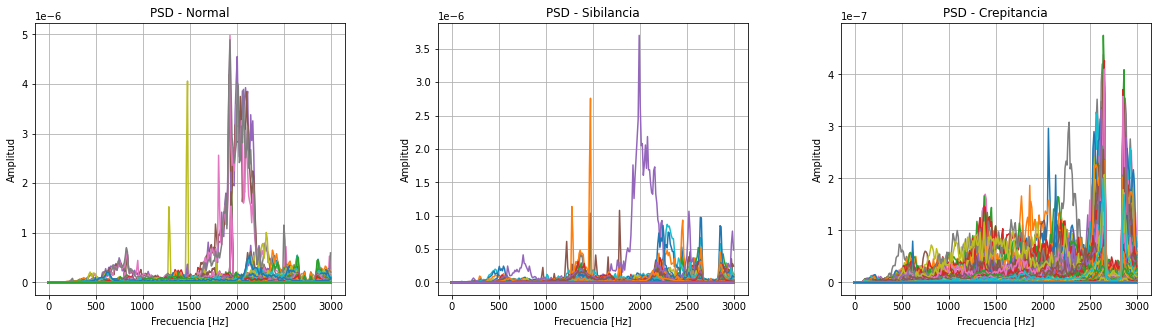

In [ ]:
#GRÁFICAS DE LA DENSIDAD ESPECTRAL DE POTENCIA PARA CADA UNO DE LOS CICLOS RESPIRATORIOS.  
px_n=[]
px_s=[]
px_c=[]

#PSD para ciclos normales. 
figura1=plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
for i in range(0,len(normal)):
  #Estimación de la densidad espectral. 
  f, Pxx = signal.welch(normal[i],fs,'hamming', 40000*0.05, 40000*0.025, scaling='density');
  plt.plot(f[f<3000],Pxx[f<3000])
  px_n.append(Pxx)
  plt.title('PSD - Normal')
  plt.xlabel('Frecuencia [Hz]')
  plt.ylabel('Amplitud')
  plt.grid()

#PSD para ciclos sibilantes.
plt.subplot(1,3,2)
for i in range(0,len(sibi)):
  #Estimación de la densidad espectral.
  fss, Pxxs = signal.welch(sibi[i],fs,'hamming', 40000*0.05, 40000*0.025, scaling='density');
  plt.plot(fss[fss<3000],Pxxs[fss<3000])
  px_s.append(Pxxs)
  plt.title('PSD - Sibilancia')  
  plt.grid()
  plt.xlabel('Frecuencia [Hz]')
  plt.ylabel('Amplitud')

#PSD para ciclos crepitantes. 
plt.subplot(1,3,3)
for i in range(0,len(crep)):
  #Estimación de la densidad espectral. 
  fcc, Pxxc = signal.welch(crep[i],fs,'hamming', 40000*0.05, 40000*0.025, scaling='density');
  plt.plot(fcc[fcc<3000],Pxxc[fcc<3000])
  px_c.append(Pxxc)
  plt.title('PSD - Crepitancia')
  plt.xlabel('Frecuencia [Hz]')
  plt.ylabel('Amplitud')
  plt.grid()
figura1.subplots_adjust(wspace=0.3,hspace=0.4) 

Las tres gráficas presentadas corresponden a la densidad espectral de potencia de cada uno de los ciclos respiratorios, donde en la gráfica número 1 se observa el comportamiento de la PSD de los ciclos normales, encontrando algunas variaciones en la amplitud de esta, apreciando algunos picos a altas frecuencias, característicos de algunos ciclos, los cuales pueden estar relacionados a perturbaciones del ciclo respiratorio. De la misma manera se puede observar este comportamiento en la PSD de los ciclos sibilantes, donde también se presentan variaciones en la amplitudes. Por último en la PSD de los ciclos crepiatntes se aprecia que los espectros también presentan variaciones en su amplitud, sin embargo el comportamiento de dichos espectros es similar para la mayoria de ciclos, esto se debe a que los pacientes evaluados pueden presentar diferencias en la severidad de los sonidos crepitantes en su respiración.

### **Densidad espectral de potencia promedio**

In [ ]:
#CÁLCULO DE LA DENSIDAD ESPECTRAL DE POTENCIA PROMEDIO PARA CADA UNO DE LOS CICLOS RESPIRATORIOS.  
#PSD promedio para los ciclos normales.
pr=[]
#Ciclo que devuelve los datos de la PSD del ciclo en la posición cero. 
for i in range(0,len(px_n[0])):
  V=[]
  #Ciclo que recorre cada una de las posiciones de la PSD para ser guardadas en una nueva lista vacía. 
  for j in range(0,len(px_n)):
    v=px_n[j][i]
    V.append(v)
  pr.append(V)  
pr_n=[]
#Ciclo para el cálculo de la PSD promedio. 
for h in range(0,len(pr)):
  proms=np.mean(pr[h])
  pr_n.append(proms)

#PSD promedio para los ciclos crepitantes.
pr1=[]
#Ciclo que devuelve los datos de la PSD del ciclo en la posición cero. 
for i in range(0,len(px_c[0])):
  V1=[]
  #Ciclo que recorre cada una de las posiciones de la PSD para ser guardadas en una nueva lista vacía.
  for j in range(0,len(px_c)):
    v1=px_c[j][i]
    V1.append(v1)
  pr1.append(V1)
pr_c=[]
#Ciclo para el cálculo de la PSD promedio.
for h in range(0,len(pr1)):
  proms1=np.mean(pr1[h])
  pr_c.append(proms1)

#PSD promedio para los ciclos sibilantes.
pr2=[]
#Ciclo que devuelve los datos de la PSD del ciclo en la posición cero. 
for i in range(0,len(px_s[0])):
  V2=[]
  #Ciclo que recorre cada una de las posiciones de la PSD para ser guardadas en una nueva lista vacía.
  for j in range(0,len(px_s)):
    v2=px_s[j][i]
    V2.append(v2)
  pr2.append(V2)
pr_s=[]
#Ciclo para el cálculo de la PSD promedio. 
for h in range(0,len(pr2)):
  proms2=np.mean(pr2[h])
  pr_s.append(proms2)

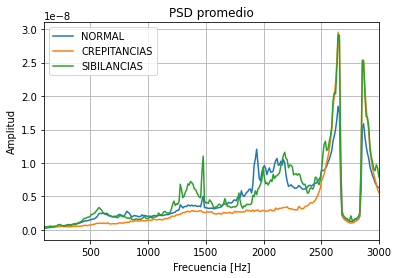

In [ ]:
#APLICACIÓN y GRÁFICAS DE LA PSD PROMEDIO PARA CADA UNO DE LOS CICLOS RESPIRATORIOS. 
#Se convierte la frecuencia a un array. 
f = np.asfortranarray(f)

#Gráfica de los ciclos normales. 
pr_n=np.asfortranarray(pr_n)
plt.plot(f[f<3000],pr_n[f<3000],label='NORMAL')


#Gráfica de los ciclos crepitantes.
pr_c=np.asfortranarray(pr_c)
plt.plot(f[f<3000],pr_c[f<3000],label='CREPITANCIAS')

#Gráfica de los ciclos sibilantes. 
pr_s=np.asfortranarray(pr_s)
plt.plot(f[f<3000],pr_s[f<3000],label='SIBILANCIAS')

#Se grafican el promedio de los ciclos en una sola gráfica.
plt.xlim(100,3000)
plt.title('PSD promedio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()


El gráfico presentado corresponde al promedio de la densidad espectral de potencia de los ciclos normales, crepitantes y sibilantes, en el se obsevan diferencias en las amplitudes de los ciclos mencionados, observando que en el rango de frecuencias entre 1250 y 1500 se presenta la mayor diferencia de amplitudes de frecuencia entre las tres poblaciones estudiadas.

Por otro lado, se puede percibir que en los ciclos crepitantes no hay picos de amplitud notorios, lo que hace que la curva sea más homogenea, mientras que en las curvas de sibilancias y normal se observan picos de amplitud producto del comportamiento de los graficos de los espectros individuales de los ciclos.

Finalmente, es posible observar que la principal diferencia entre los ciclos crepitantes, sibilantes y normales radica en la amplitud del espectro de densidad de potencia, el cual a frecuencia medias es mayor para ciclos sibilantes y menor para ciclos crepitantes. A demás es notorio que a pesar de que los ciclos sibilantes, normales y crepitantes poseen caracteristicas diferentes, su comportamiento de las curvas en el dominio de la frecuencia es similar.


## **7. Índices en el dominio del tiempo y frecuencia**

In [ ]:
#Función para el cálculo de índices. 
def indices(ciclo):
  #Cálculo de varianza.
  var=np.var(ciclo)

  #Cálculo del rango.
  rango=np.abs(max(ciclo)-min(ciclo))

  #Cálculo de la suma de la media móvil simple.
  s=[]
  ss=[]
  sum_d=[]
  w=0
  #Lista para guardar las ventanas
  win_1=[]
  #Ciclo para extraer las ventanas
  for i in range(0,20):
    win=ciclo[int(w):int((len(ciclo)*0.05)+w)] 
    #Solapamiento
    w=int(w+1000) 
    win_1.append(win) 
  #Cálculo de la suma gruesa
  for i in range(1,len(ciclo)):
    si=np.abs(ciclo[i-1]-ciclo[i])
    s.append(si)
  suma_g=np.sum(s)
  #Cálculo de la suma fina
  for i in range(1,len(win_1)):
    su=np.abs(win_1[i-1]-win_1[i])
    ss.append(su)
    suma_d=np.sum(ss)
    sum_d.append(suma_d)
  suma_f=max(sum_d)
  fs=22050
  #Cálculo de la densidad espectral de potencia promedio
  f, Pxx = signal.welch(ciclo,fs,'hamming', 40000*0.05, 40000*0.025, scaling='density');
  esp_m=np.mean(Pxx)

  #Cálculo del índice adicional, donde se maxima la diferencia de los espectros.
  E=Pxx[227:272]
  prome=np.mean(E)

  return var,rango,suma_g,suma_f,esp_m,prome

In [ ]:
#EJEMPLO DEL CÁLCULO DE INDICES.
v,r,sg,sf,e,E=indices(sibi[2])

#Se imprimen los valores de los indices respectivos. 
print('Varianza: ',v)
print('Rango: ',r)
print('Suma de la media móvil simple gruesa: ', sg)
print('Suma de la media móvil simple fina: ', sf)
print('Valor medio del espectro: ', e)
print('Valor medio rango diferencial del espectro: ', E)

Varianza:  3.131647562542854e-07
Rango:  0.005504695347368294
Suma de la media móvil simple gruesa:  12.770745189544103
Suma de la media móvil simple fina:  21.179668562662766
Valor medio del espectro:  2.8244388395948037e-11
Valor medio rango diferencial del espectro:  6.366175238722861e-11


## **8. Rutina de preprocesamiento y extracción de datos**

In [ ]:
#Función que permite una mejor visualización de los DataFrame.
def displaydf(dataframe, cols = None, rows = None):
    with pd.option_context("display.max_columns", cols):
        with pd.option_context("display.max_rows", rows):
            display(dataframe)
    return True

In [ ]:
tipos=[normal,crep,sibi]
var_=[]
r_=[]
sg_=[]
sf_=[]
e_=[]
p_=[]
#Ciclo que añade a diferentes listas los índices de todos los ciclos respiratorios. 
for i in range(0,len(tipos)):
  for k in range(0,len(tipos[i])):
    var,rango,suma_g,suma_f,esp_m,prome=indices(tipos[i][k])
    var_.append(var)
    r_.append(rango)
    sg_.append(suma_g)
    sf_.append(suma_f)
    e_.append(esp_m)
    p_.append(prome)

#Se dividen cada uno de los índices correspondientes a cada grupo de ciclos respiratorios, normales, sibilantes y crepitantes. 
no=[]
for i in range(0,len(normal)):
  nn='0'
  no.append(nn)
na=[]
for i in range(0,len(sibi)):
  nn='1'
  na.append(nn)
np=[]
for i in range(0,len(crep)):
  nn='2'
  np.append(nn)

#
gp=[]
gp.extend(no)
gp.extend(np)
gp.extend(na)

#Se guarda toda la información de los índices en un dataframe discriminando cada uno de los ciclos respiratorios normales, crepitantes y sibilantes. 
CDATA=pd.DataFrame({'Varianza':pd.Series(var_),'Rango':pd.Series(r_),'SMA gruesa':pd.Series(sg_),'SMA fina':pd.Series(sf_),'Espectro medio':pd.Series(e_),'PSD prom':pd.Series(p_),'Outcome':pd.Series(gp)})


In [ ]:
#Se imprime el Dataframe que contiene los índices para los diferentes tipos de ciclos
#datos=displaydf(CDATA)
hd=['Varianza','Rango','SMA gruesa','SMA fina','Espectro medio','PSD prom','Outcome']
CDATA.to_csv ( 'DATOS1.csv' , header = True , index = False )


## **9. Análisis estadístico y pruebas de hipótesis**

In [ ]:
#ANÁLISIS DE LA VARIANZA.
#Media.
m_n=np.mean(var[0:len(normal)-1])
m_c=np.mean(var[len(normal):len(normal)+len(crep)-1])
m_s=np.mean(var[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)-1])
#Desviación estándar.
des_n=np.std(var[0:len(normal)-1])
des_c=np.std(var[len(normal):len(normal)+len(crep)-1])
des_s=np.std(var[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)-1])

#ANÁLISIS DEL ESPECTRO MEDIO.
#Media
me_n=np.mean(e[0:len(normal)-1])
me_c=np.mean(e[len(normal):len(normal)+len(crep)-1])
me_s=np.mean(e[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)-1])
#Desviación estándar
dese_n=np.std(e[0:len(normal)-1])
dese_c=np.std(e[len(normal):len(normal)+len(crep)-1])
dese_s=np.std(e[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)-1])

#ANÁLISIS DEL RANGO.
#Media
mr_n=np.mean(r[0:len(normal)-1])
mr_c=np.mean(r[len(normal):len(normal)+len(crep)-1])
mr_s=np.mean(r[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)-1])
#Desviación estándar
desr_n=np.std(r[0:len(normal)-1])
desr_c=np.std(r[len(normal):len(normal)+len(crep)-1])
desr_s=np.std(r[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)-1])

#Se agregan cada uno de los índices a una respectiva lista.
Prom=[m_n,m_c,m_s]
Prome=[me_n,me_c,me_s]
Des=[des_n,des_c,des_s]
Dese=[dese_n,dese_c,dese_s]
Rango=[mr_n,mr_c,mr_s]
Rangoe=[desr_n,desr_c,desr_s]

#Se guarda toda la información anterior en un dataframe. 
CDATAn=pd.DataFrame({'Promedio de la varianza':pd.Series(Prom),'Promedio del espectro':pd.Series(Prome),'STD de la varianza':pd.Series(Des),'STD del espectro':pd.Series(Dese),'Promedio del rango':pd.Series(Rango),'STD del rango':pd.Series(Rangoe)})
CDATAn.index=['NORMAL','CREPITANCIAS','SIBILANCIAS']
CDATAn=displaydf(CDATAn)
print(CDATAn)

,Promedio de la varianza,Promedio del espectro,STD de la varianza,STD del espectro,Promedio del rango,STD del rango
NORMAL,0.000021,1.872195e-09,0.000070,6.318583e-09,0.027203,0.032250
CREPITANCIAS,0.000016,1.451137e-09,0.000025,2.316520e-09,0.030791,0.023537
SIBILANCIAS,0.000024,2.185597e-09,0.000063,5.806197e-09,0.031282,0.034920


True


### **Pruebas de hipótesis**

**Varianza**



H 0 : La varianza de los ciclos respiratorios es igual entre los ciclos normales y crepitantes. 

H A : La varianza de los ciclos respiratorios no es igual entre los ciclos normales y crepitantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(var[0:len(normal)] , var[len(normal):len(normal)+len(crep)]) 
print ('Valor P:', pVal)

Valor P: 4.378403707987563e-24


* Dado que el valor p (4.378e-24) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre la varianza de los ciclos respiratorios normales y sibilantes.

H 0 : La varianza de los ciclos respiratorios es igual entre los ciclos normales y sibilantes. 

H A : La varianza de los ciclos respiratorios no es igual entre los ciclos normales y sibilantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(var[0:len(normal)] , var[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)]) 
print ('Valor P:', pVal)

Valor P: 0.0008827703614966793


*  Dado que el valor p (8.82e-04) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre la varianza de los ciclos respiratorios normales y crepitantes.


**Rango**




H 0 : El rango de los ciclos respiratorios es igual entre los ciclos normales y crepitantes.

H A : El rango de los ciclos respiratorios no es igual entre los ciclos normales y crepitantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(r[0:len(normal)] , r[len(normal):len(normal)+len(crep)])
print ('Valor P:', pVal)

Valor P: 1.1523410580682039e-27


*  Dado que el valor p (1.15e-27) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre el rango de los ciclos respiratorios normales y crepitantes.

H 0 : El rango de los ciclos respiratorios es igual entre los ciclos normales y sibilantes.

H A : El rango de los ciclos respiratorios no es igual entre los ciclos normales y sibilantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(r[0:len(normal)] , r[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)]) 
print ('Valor P:', pVal)

Valor P: 0.0007150008756986521


*  Dado que el valor p (0.000715) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre el rango de los ciclos respiratorios normales y sibilantes.

**SMA gruesa**

H 0 : La SMA de los ciclos respiratorios es igual entre los ciclos normales y crepitantes.

H A : La SMA de los ciclos respiratorios no es igual entre los ciclos normales y crepitantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(sg[0:len(normal)] , sg[len(normal):len(normal)+len(crep)]) 
print ('Valor P:', pVal)

Valor P: 4.506518565320068e-24


*  Dado que el valor p (4.50e-24) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre la SMA gruesa de los ciclos respiratorios normales y crepitantes.

H 0 : La SMA de los ciclos respiratorios es igual entre los ciclos normales y sibilantes.

H A : La SMA de los ciclos respiratorios no es igual entre los ciclos normales y sibilantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(sg[0:len(normal)] , sg[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)]) 
print ('Valor P:', pVal)

Valor P: 0.00022390976295266155


*  Dado que el valor p (0.000223) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre la SMA gruesa de los ciclos respiratorios normales y sibilantes.

**SMA fina**

H 0 : La SMA fina de los ciclos respiratorios es igual entre los ciclos normales y crepitantes.

H A : La SMA fina de los ciclos respiratorios no es igual entre los ciclos normales y crepitantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(sf[0:len(normal)] , sf[len(normal):len(normal)+len(crep)]) 
print ('Valor P:', pVal)

Valor P: 3.9947870134928154e-28


*  Dado que el valor p (3.994e-28) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre la SMA fina de los ciclos respiratorios normales y crepitantes.

H 0 : La SMA fina de los ciclos respiratorios es igual entre los ciclos normales y sibilantes.

H A : La SMA fina de los ciclos respiratorios no es igual entre los ciclos normales y sibilantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(sf[0:len(normal)] , sf[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)]) 
print ('Valor P:', pVal)

Valor P: 0.0004209959789440229


*  Dado que el valor p (0.00042) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre la SMA fina de los ciclos respiratorios normales y sibilantes.

**Espectro medio**

H 0 : El espectro medio de los ciclos respiratorios es igual entre los ciclos normales y crepitantes.

H A : El espectro medio de los ciclos respiratorios no es igual entre los ciclos normales y crepitantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(e[0:len(normal)] , e[len(normal):len(normal)+len(crep)]) 
print ('Valor P:', pVal)

Valor P: 4.249476324025359e-24


*  Dado que el valor p (4.249e-24) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre el espectro medio de los ciclos respiratorios normales y crepitantes.

H 0 :  El espectro medio de los ciclos respiratorios es igual entre los ciclos normales y sibilantes.

H A :  El espectro medio de los ciclos respiratorios no es igual entre los ciclos normales y sibilantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(e[0:len(normal)] , e[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)]) 
print ('Valor P:', pVal)

Valor P: 0.0008735614461393159


*  Dado que el valor p (0.000873) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre el espectro medio de los ciclos respiratorios normales y sibilantes.

**PSD prom**

H 0 : El PSD promedio de los ciclos respiratorios es igual entre los ciclos normales y crepitantes.

H A : El PSD promedio de los ciclos respiratorios no es igual entre los ciclos normales y crepitantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(p[0:len(normal)] , p[len(normal):len(normal)+len(crep)]) 
print ('Valor P:', pVal)

Valor P: 3.6547881610887036e-13


*  Dado que el valor p (3.65e-13) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre el PSD promedio de los ciclos respiratorios normales y crepitantes.

H 0 : El PSD promedio de los ciclos respiratorios es igual entre los ciclos normales y sibilantes.

H A : El PSD promedio de los ciclos respiratorios no es igual entre los ciclos normales y sibilantes.

In [ ]:
#Se aplica el test de Mann-Whitney.
u_statistic, pVal = stats.mannwhitneyu(p[0:len(normal)] , p[len(normal)+len(crep):len(normal)+len(crep)+len(sibi)])
print ('Valor P:', pVal)

Valor P: 0.4751709172955538


*  Dado que el valor p (0.475) es mayor que 0.05, no se rechaza. No se tiene evidencia suficiente para decir que no existe una diferencia entre el PSD promedio de los ciclos respiratorios normales y sibilantes.

### **Análisis de resultados**

Con el fin de realizar un análisis estadístico del comportamiento de los ciclos respiratorios se extrajeron las características estadisticas básicas de los índices que describen el comportamiento temporal y frecuencial de cada uno de los ciclos respiratorios extraidos de la base de datos *'Respiratory Sound Database'*, encontrando que existe una mayor varianza en los ciclos sibilantes y normales con relación a los crepitantes, así mismo se observa que la densidad espectral de potencia es en promedio mayor en los ciclos que presentan sibilancias, seguido de los normales y crepitantes. Por otro lado se caracterizó la varianza de los ciclos y del espectro mediante la desviación estandar, encontrando una mayor dispersión en la varianza de los ciclos normales, seguido de los sibilantes y por último crepitantes, así mismo, los resultados relacionados con la desviación estandar del espectro sugieren una mayor dispersión del espectro promedio de los ciclos normales, seguido de los sibilantes y crepitantes, finalmente, se analiza el promedio y la desviación estandar del rango, obteniendo en promedio un mayor rango de amplitud para las sibilancias y el menor para los normales; en el caso de la desviación estandar de los rangos, la mayor variación se presenta en los ciclos sibilantes y la menor en los crepitantes.

Posteriormente, mediante las pruebas de hipótesis realizadas, se encuentra que es posible diferenciar los ciclos normales de los crepitantes o sibilantes a partir de la extracción de los indices que describen el comportamiento frecuencial y temporal de los ciclos respiratorios. Dado que el resultado del valor p en la mayoría es menor a 0.05 en los indices extraídos anteriormente es posible decir que son un parámetro que sirve para diferenciar los ciclos respiratorios normales de los sibilantes y normales de los crepitantes. En cuanto a la prueba de hipótesis realizada para el PSD promedio donde se maximiza la diferencia entre los ciclos respiratorios normales y sibilantes, se determina que el valor p resultante esta por fuera del nivel de significancia aceptado, lo que da cuenta de que en dicho rango de frecuencias (1250Hz y 1500Hz) no se puede determinar una diferencia entre un ciclo sibilante y un ciclo normal, por lo que sería necesario determinar un nuevo rango de frecuencias que permita relacionar la diferencia del espectro de la densidad de potencia entre los ciclos normales y con sibilancias, ya que en el presente trabajo, solo se determina un rango para los tres grupos. 

Finalmente, gracias al preprocesamiento y procesamiento de los datos, a partir de filtros pasa altas, pasa bajas y pasa bandas, los cuales permiten la eliminación de frecuencias que no son de interés para el estudio, además del filtrado Wavelet que permite eliminar sonidos externos asociados al latido del corazón, es posible extraer de las señales obtenidas mediante la auscultación información libre de perturbaciones externas o ruido que impiden un adecuado análisis de los ciclos respiratorios. Lo anterior es muy útil para realizar diagnósticos de afectaciones clínicas que relacionen el sistema respiratorio. 

In [ ]:
#Función definida para realizar el preprocesamiento y la extracción de todas las características anteriormente hechas. 
def rutina_final(au,txt):
  #Se llama la función que recorta los ciclos respiratorios. 
  normal,crep,sibi,ln,lnc,lns=recorte(au,txt)
  tipos=[normal,crep,sibi]
  var_=[]
  r_=[]
  sg_=[]
  sf_=[]
  e_=[]
  p_=[]
  #Ciclo que añade a diferentes listas los índices de todos los ciclos respiratorios. 
  for i in range(0,len(tipos)):
    for k in range(0,len(tipos[i])):
      var,rango,suma_g,suma_f,esp_m,prome=indices(tipos[i][k])
      var_.append(var)
      r_.append(rango)
      sg_.append(suma_g)
      sf_.append(suma_f)
      e_.append(esp_m)
      p_.append(prome)

  #Se dividen cada uno de los índices correspondientes a cada grupo de ciclos respiratorios, normales, sibilantes y crepitantes. 
  no=[]
  for i in range(0,len(normal)):
    nn='Normal'
    no.append(nn)
  na=[]
  for i in range(0,len(sibi)):
    nn='Sibilancia'
    na.append(nn)
  np=[]
  for i in range(0,len(crep)):
    nn='Crepitancia'
    np.append(nn)

  #
  gp=[]
  gp.extend(no)
  gp.extend(np)
  gp.extend(na)

  #Se guarda toda la información de los índices en un dataframe discriminando cada uno de los ciclos respiratorios normales, crepitantes y sibilantes. 
  CDATA=pd.DataFrame({'Varianza':pd.Series(var_),'Rango':pd.Series(r_),'SMA gruesa':pd.Series(sg_),'SMA fina':pd.Series(sf_),'Espectro medio':pd.Series(e_),'PSD prom':pd.Series(p_)})
  CDATA.index=gp
  
  return var_,r_,sg_,sf_,e_,p_,CDATA

In [ ]:
%%capture
## Aplicación de preprocesamiento y procesamiento de datos
var,r,sg,sf,e,p,datos=rutina_final(wav,txt)